In [0]:
import numpy as np
import zipfile

import glob

#Loading and Extracting the dataset 

z = zipfile.ZipFile('Source2.zip', "r")
for name in z.namelist():
    z.extract(name)

data = [f for f in glob.glob("Source1/*")]
data.extend([f for f in glob.glob("Source2/*")])
data.extend([f for f in glob.glob("Source5/*")])

In [0]:
import pandas as pd
#Loading Training Label. Here I have used only ('Source-1','Source-2','Source-5') data

label_train=pd.read_csv('Train_Combined.csv')
label_test=pd.read_csv('Test_Combined.csv')
temp=label_train.where(label_train['Data Source'].str.contains('|'.join(('Source-1','Source-2','Source-5'))))
temp.reset_index(inplace=True,drop=True)
temp.dropna(inplace=True)

label_train=temp

#Loading Testing Label. Here I have used only ('Source-1','Source-2','Source-5') data

temp=label_test.where(label_test['Data Source'].str.contains('|'.join(('Source-1','Source-2','Source-5'))))
temp.reset_index(inplace=True,drop=True)
temp.dropna(inplace=True)
label_test=temp

In [0]:
#Upsampling the minority classes for handling class imbalance
max=0
for stri in ['Non-Pneumonia','Other Pneumonia','COVID-19']:
  if label_train[stri].sum()>max:
    max=label_train[stri].sum()

for stri in ['Non-Pneumonia','Other Pneumonia','COVID-19']:
  if label_train[stri].sum()<max:
    temp=label_train.where(label_train[stri]==1.0)
    temp.dropna(inplace=True)
    idx=np.random.choice(temp.index,size=int(max-label_train[stri].sum()),replace=True)
    label_train=label_train.append(label_train.loc[idx],ignore_index=True)



In [0]:
from torchvision import models
train_on_gpu=0
def get_pretrained_model(model_name):
 
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)


        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features


        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 3), nn.LogSoftmax(dim=1))



    return model

In [0]:
from torchsummary import summary
import torch.nn as nn
# Loading pretrained model 'vgg16'

model = get_pretrained_model('vgg16')

#calculating the model space and inference compute complexity

summary(model, input_size=(3, 224, 224), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

In [0]:
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Epoch 0 - Training loss: 0.6422485480754895, Validation loss: 0.3762445672369557, validation accuracy: 0.8090909090909091
Epoch 1 - Training loss: 0.42460843943407545, Validation loss: 0.30111689886764037, validation accuracy: 0.8909090909090909
Epoch 2 - Training loss: 0.34761605924145034, Validation loss: 0.2999498074342235, validation accuracy: 0.8454545454545455
Epoch 3 - Training loss: 0.3202098380988974, Validation loss: 0.27497956778287946, validation accuracy: 0.8636363636363636
Epoch 4 - Training loss: 0.306457814899253, Validation loss: 0.27998436268705096, validation accuracy: 0.8727272727272727
Epoch 5 - Training loss: 0.2997619844402321, Validation loss: 0.22096010584129638, validation accuracy: 0.9181818181818182
Epoch 6 - Training loss: 0.2663901454168446, Validation loss: 0.2670119025223596, validation accuracy: 0.8727272727272727
Epoch 7 - Training loss: 0.2375673808647614, Validation loss: 0.3777034462563111, validation accuracy: 0.8727272727272727
Epoch 8 - Training 

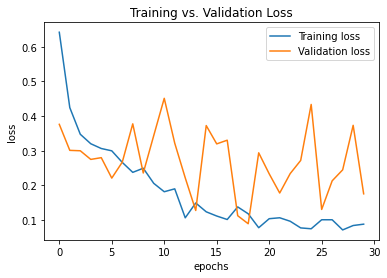

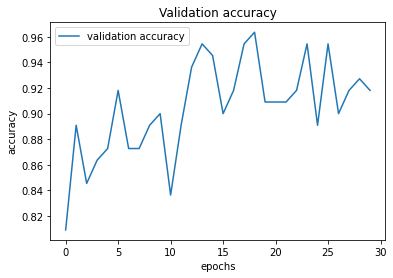


Training Time (in minutes) = 235.94575689236322


In [0]:
import cv2
from time import time
import torch
import torch.optim as optim
from sklearn.model_selection  import train_test_split 
import torch.optim.lr_scheduler as Scheduler
import matplotlib.pyplot as plt

# ReduceLROnPlateau scheduler with validation loss monitoring is used for hot restart during training

scheduler=Scheduler.ReduceLROnPlateau(optimizer,'min')
time0 = time()
epochs = 30

previous_running_loss_val=0
running_loss_val = 0
max_patience_count=7
train_loss=[]
validation_loss=[]
validation_accuracy=[]
for e in range(epochs):
    previous_running_loss_val=running_loss_val
    running_loss_train = 0
    running_loss_val = 0
    pos_count=0
# Random Split of training and validation set from the training data with validation size 15% of training.

    
    train_label, val_label = train_test_split(label_train, test_size=0.15,random_state=1)

    for i in train_label.index:
        labels=torch.from_numpy(np.expand_dims(np.array(train_label.loc[i][['Non-Pneumonia','Other Pneumonia','COVID-19']]).astype(np.int),0))
        img_name=train_label.loc[i]['Image Name']
        source=train_label.loc[i]['Data Source'].replace('-','')
        indx=data.index("/".join([source,img_name]))
        img=cv2.imread(data[indx])
        img=cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
        img=np.transpose(img)/255.0
        images=torch.from_numpy(np.expand_dims(img.astype('float32'),0))
        optimizer.zero_grad()
        
        output = model(images)
        loss =criterion(output, labels.argmax(dim=1))
        
        
        loss.backward()
        
        
        optimizer.step()
        
        running_loss_train += loss.item()

    for i in val_label.index:
        labels=torch.from_numpy(np.expand_dims(np.array(val_label.loc[i][['Non-Pneumonia','Other Pneumonia','COVID-19']]).astype(np.int),0))
        img_name=val_label.loc[i]['Image Name']
        source=val_label.loc[i]['Data Source'].replace('-','')
        indx=data.index("/".join([source,img_name]))
        img=cv2.imread(data[indx])
        img=cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
        img=np.transpose(img)/255.0
        images=torch.from_numpy(np.expand_dims(img.astype('float32'),0))

        
        
        output = model(images)
        
        loss =criterion(output, labels.argmax(dim=1))
        MAX=np.argmax(output.detach().numpy())
        if int(np.argmax(labels))==MAX:
          pos_count +=1
        
        
        running_loss_val += loss.item()

    else:
# Scheduler step
        scheduler.step(previous_running_loss_val)

        train_loss.append(running_loss_train/len(train_label))
        validation_loss.append(running_loss_val/len(val_label))
        validation_accuracy.append(pos_count/len(val_label))
        print("Epoch {} - Training loss: {}, Validation loss: {}, validation accuracy: {}".format(e, running_loss_train/len(train_label),running_loss_val/len(val_label),pos_count/len(val_label)))

#Plotting Training and validation loss
x1 = range(epochs)
y1 = train_loss
plt.plot(x1, y1, label = "Training loss")
x2 = range(epochs)
y2 = validation_loss
plt.plot(x2, y2, label = "Validation loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()
x1=range(epochs)
y1=validation_accuracy
plt.plot(x1,y1,label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Validation accuracy')
plt.legend()
plt.show()
print("\nTraining Time (in minutes) =",(time()-time0)/60)


In [0]:
# Saving the model state
torch.save(model.state_dict(),'Trainedmodel_state_dict.tar')

In [0]:
# Testing model accuracy
pos_count=0
for i in label_test.index:
    labels=torch.from_numpy(np.expand_dims(np.array(label_test.loc[i][['Non-Pneumonia','Other Pneumonia','COVID-19']]).astype(np.int),0))
    img_name=label_test.loc[i]['Image Name']
    source=label_test.loc[i]['Data Source'].replace('-','')
    indx=data.index("/".join([source,img_name]))
    img=cv2.imread(data[indx])
    img=cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
    img=np.transpose(img)/255.0
    images=torch.from_numpy(np.expand_dims(img.astype('float32'),0))

    
    
    output = model(images)
    
    MAX=np.argmax(output.detach().numpy())
    if int(np.argmax(labels))==MAX:
      pos_count +=1
    
print('Testing accuracy is: {}'.format(pos_count/len(label_test)*100))
  

Testing accuracy is: 71.66666666666667
